In [1]:
import numpy as np
import torch
print(torch.__version__)

1.11.0


### Работа с тензорами, повторение

In [2]:
x = np.arange(16).reshape(4, 4)

x = torch.tensor(x, dtype=torch.float32)  # or torch.arange(0, 16).view(4, 4)

print("X:\n%s" % x)
print("X.shape: %s\n" % (x.shape,))
print("add 5:\n%s" % (x + 5))
print("X*X^T:\n%s" % torch.matmul(x, x.transpose(1, 0)))  # short: x.mm(x.t())
print("mean over rows:\n%s" % torch.mean(x, dim=-1))
print("cumsum of cols:\n%s" % torch.cumsum(x, dim=0))

X:
tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.],
        [12., 13., 14., 15.]])
X.shape: torch.Size([4, 4])

add 5:
tensor([[ 5.,  6.,  7.,  8.],
        [ 9., 10., 11., 12.],
        [13., 14., 15., 16.],
        [17., 18., 19., 20.]])
X*X^T:
tensor([[ 14.,  38.,  62.,  86.],
        [ 38., 126., 214., 302.],
        [ 62., 214., 366., 518.],
        [ 86., 302., 518., 734.]])
mean over rows:
tensor([ 1.5000,  5.5000,  9.5000, 13.5000])
cumsum of cols:
tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  6.,  8., 10.],
        [12., 15., 18., 21.],
        [24., 28., 32., 36.]])


## Automatic gradients - автоматический расчет градиента

Any self-respecting DL framework must do your backprop for you. Torch handles this with the `autograd` module.

The general pipeline looks like this:
* When creating a tensor, you mark it as `requires_grad`:
    * `torch.zeros(5, requires_grad=True)`
    * `torch.tensor(np.arange(5), dtype=torch.float32, requires_grad=True)`
* Define some differentiable `loss = arbitrary_function(a)`
* Call `loss.backward()`
* Gradients are now available as ```a.grad```

__Here's an example:__ let's fit a linear regression on Boston house prices.

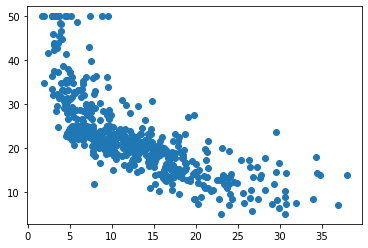

In [27]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
boston = load_boston()
plt.scatter(boston.data[:, -1], boston.target)

In [166]:
w = torch.zeros(1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

x = torch.tensor(boston.data[:, -1] / 10, dtype=torch.float32)
y = torch.tensor(boston.target, dtype=torch.float32)

In [82]:
y_pred = w * x + b
loss = torch.mean((y_pred - y)**2)

# propagate gradients
loss.backward()

The gradients are now stored in `.grad` of those variables that require them.

In [83]:
print("dL/dw = \n", w.grad)
print("dL/db = \n", b.grad)

dL/dw = 
 tensor([-47.3514])
dL/db = 
 tensor([-45.0656])


In [84]:
 w.data = w.data -  0.05 * w.grad.data

Работа со значениями тензора, хранящими градиент

In [114]:
#tensor.detach() creates a tensor that shares storage with tensor that does not require grad. 
#You should use detach() when attempting to remove a tensor from a computation graph
w = torch.ones(2, requires_grad=True)
w_detached = w.detach()
print("w = ", w)
print("w_detached = ",w_detached)
w_detached.zero_()
print("w.detach() changed")
print("w_detached = ",w_detached)
print("w = ",w)

w =  tensor([1., 1.], requires_grad=True)
w_detached =  tensor([1., 1.])
w.detach() changed
w_detached =  tensor([0., 0.])
w =  tensor([0., 0.], requires_grad=True)


In [115]:
#tensor.clone()creates a copy of tensor that imitates the original tensor's requires_grad field.
w = torch.ones(2, requires_grad=True)
w_cloned = w.clone()
print("w = ", w)
print("w_cloned = ",w_cloned)
w_cloned.zero_()
print("w_cloned changed")
print("w_cloned = ",w_cloned)
print("w = ",w)

w =  tensor([1., 1.], requires_grad=True)
w_cloned =  tensor([1., 1.], grad_fn=<CloneBackward0>)
w_cloned changed
w_cloned =  tensor([0., 0.], grad_fn=<ZeroBackward0>)
w =  tensor([1., 1.], requires_grad=True)


detach() detaches the output from the computationnal graph. So no gradient will be backproped along this variable.
torch.no_grad says that no operation should build the graph.

The difference is that one refers to only a given variable on which it’s called. The other affects all operations taking place within the with statement.

In [130]:
w = torch.ones(2, requires_grad=True)
o = w.sum()
print("o:\n%s"%o)
o.backward()
print("w.grad:\n%s"%w.grad)

o:
tensor(2., grad_fn=<SumBackward0>)
w.grad:
tensor([1., 1.])


In [132]:
w = torch.ones(2, requires_grad=True)
with torch.no_grad():
    o = w.sum()
    print("o:\n%s"%o)
try:
    print(o.backward())    
    print("w.grad:", w.grad)
except:
    print("o.requires_grad:\n%s"%o.requires_grad)

o:
tensor(2.)
o.requires_grad:
False


## Алгоритм решения задачи регрессии

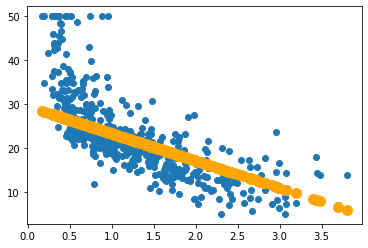

loss =  44.815567


In [119]:
from IPython.display import clear_output

w = torch.zeros(1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

for i in range(100):
    y_pred = w * x + b
    loss = torch.mean((y_pred - y)**2)
    loss.backward()

    w.data -= 0.05 * w.grad.data
    b.data -= 0.05 * b.grad.data

    # zero gradients
    w.grad.data.zero_()
    b.grad.data.zero_()

    # the rest of code is just bells and whistles
    if (i + 1) % 5 == 0:
        clear_output(True)
        plt.scatter(x.numpy(), y.numpy())
        plt.scatter(x.numpy(), y_pred.detach().numpy(), color='orange', linewidth=5)
        plt.show()

        print("loss = ", loss.detach().numpy())
        if loss.detach().numpy() < 0.5:
            print("Done!")
            break

### Модуль nn

In [134]:
from torch import nn
import torch.nn.functional as F

print(nn.Module.__doc__)

Base class for all neural network modules.

    Your models should also subclass this class.

    Modules can also contain other Modules, allowing to nest them in
    a tree structure. You can assign the submodules as regular attributes::

        import torch.nn as nn
        import torch.nn.functional as F

        class Model(nn.Module):
            def __init__(self):
                super().__init__()
                self.conv1 = nn.Conv2d(1, 20, 5)
                self.conv2 = nn.Conv2d(20, 20, 5)

            def forward(self, x):
                x = F.relu(self.conv1(x))
                return F.relu(self.conv2(x))

    Submodules assigned in this way will be registered, and will have their
    parameters converted too when you call :meth:`to`, etc.

    .. note::
        As per the example above, an ``__init__()`` call to the parent class
        must be made before assignment on the child.

    :ivar training: Boolean represents whether this module is in training or
         

In [246]:
model = torch.nn.Sequential(
    torch.nn.Linear(1, 1),
    torch.nn.Flatten(0, 1)
)
print(model)

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
  (1): Flatten(start_dim=0, end_dim=1)
)


In [247]:
print("Weight shapes:", [(w.shape, w.dtype) for w in model.parameters()])

Weight shapes: [(torch.Size([1, 1]), torch.float32), (torch.Size([1]), torch.float32)]


In [248]:
# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use RMSprop; the optim package contains many other
# optimization algorithms. The first argument to the RMSprop constructor tells the
# optimizer which Tensors it should update.
learning_rate = 0.05
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

In [249]:
loss_fn = torch.nn.MSELoss(reduction='mean')

In [250]:
x = torch.tensor(boston.data[:, -1:] / 10, dtype=torch.float32)
y = torch.tensor(boston.target, dtype=torch.float32)

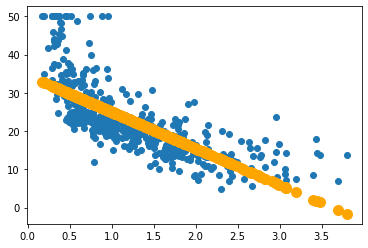

4999 38.48648452758789


In [251]:
for t in range(5000):
    
    y_pred = model(x)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)


    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()
    
    if t % 100 == 99:
        clear_output(True)
        plt.scatter(x.numpy(), y.numpy())
        plt.scatter(x.numpy(), y_pred.detach().numpy(), color='orange', linewidth=5)
        plt.show()
        
        print(t, loss.item())

In [232]:
list(model.parameters())

[Parameter containing:
 tensor([[-9.4955]], requires_grad=True),
 Parameter containing:
 tensor([34.5588], requires_grad=True)]

### Более сложная модель (внутренний слой)

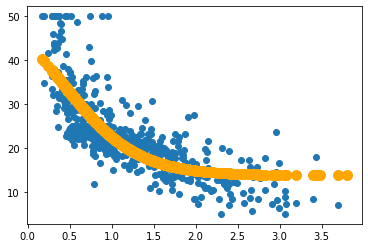

4999 29.810152053833008


In [264]:
# model = torch.nn.Sequential(
#     torch.nn.Linear(1, 4),
#     torch.nn.ReLU(),
#     torch.nn.Linear(4, 1),
#     torch.nn.Flatten(0, 1),
# )
model = torch.nn.Sequential(
    torch.nn.Linear(1, 8),
    torch.nn.Sigmoid(),
    torch.nn.Linear(8, 1),
    torch.nn.Flatten(0, 1),
)

learning_rate = 1e-2
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.MSELoss(reduction='mean')

for t in range(5000):
    
    y_pred = model(x)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)


    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()
    
    if t % 100 == 99:
        clear_output(True)
        plt.scatter(x.numpy(), y.numpy())
        plt.scatter(x.numpy(), y_pred.detach().numpy(), color='orange', linewidth=5)
        plt.show()
        
        print(t, loss.item())

### Еще один способ задания модели

In [ ]:
class Polynomial3(torch.nn.Module):
    def __init__(self):
        """
        In the constructor we instantiate four parameters and assign them as
        member parameters.
        """
        super().__init__()
        self.a = torch.nn.Parameter(torch.randn(()))
        self.b = torch.nn.Parameter(torch.randn(()))
        self.c = torch.nn.Parameter(torch.randn(()))
        self.d = torch.nn.Parameter(torch.randn(()))

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        return self.a + self.b * x + self.c * x ** 2 + self.d * x ** 3

    def string(self):
        """
        Just like any class in Python, you can also define custom method on PyTorch modules
        """
        return f'y = {self.a.item()} + {self.b.item()} x + {self.c.item()} x^2 + {self.d.item()} x^3'